<a href="https://colab.research.google.com/github/aaroncdvd/HRBS-CA_Python_AI/blob/main/PredictDiabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How can we use an ML model with the diabetes patient data?

![](https://miro.medium.com/max/2066/1*wWRGcsBwoXw-WNJi5UpoOw.png)

##Prepare

![](https://hackr.io/blog/sql-cheat-sheet/thumbnail/large)

###Download CSV to SQL

In [ ]:
!apt-get install sqlite3 # Install SQLite

Reading package lists... Done
Building dependency tree       
Reading state information... Done
sqlite3 is already the newest version (3.22.0-1ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


*Create SQL Database*

In [ ]:
![ -e diabetes.csv.db ] && rm diabetes.csv.db # Remove Existing SQL Files and Load New SQL From CSV
!wget -O - -o /dev/null 'https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv'|sqlite3 -csv diabetes.csv.db ".import /dev/stdin diabetes_csv"

In [ ]:
!sqlite3 diabetes.csv.db ".tables" # List SQL Tables (Like Excel 'Sheets')

diabetes_csv


*Query Diabetes.csv using SQL*

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select * from diabetes_csv limit 1"

Pregnancies  Glucose     BloodPressure  SkinThickness  Insulin     BMI         DiabetesPedigreeFunction  Age         Outcome   
-----------  ----------  -------------  -------------  ----------  ----------  ------------------------  ----------  ----------
6            148         72             35             0           33.6        0.627                     50          1         


###Exercise: Let's find Average BMI for patients with and without diabetes!

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select Outcome,avg(BMI),count(*) as Patient from diabetes_csv group by Outcome"

Outcome     avg(BMI)    Patient   
----------  ----------  ----------
0           30.3042     500       
1           35.1425373  268       


*Make it Pretty!*

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select case when Outcome=0 then 'no diabetes' else 'diabetes' end as Diagnosis,avg(BMI) AveraveBMI from diabetes_csv group by Outcome"

Diagnosis    AveraveBMI
-----------  ----------
no diabetes  30.3042   
diabetes     35.1425373


*Save the results as a Virtual Table: Average_BMI*

In [ ]:
!sqlite3 diabetes.csv.db "drop view if exists average_BMI; create view average_BMI as \
select case when Outcome=0 then 'no diabetes' else 'diabetes' end as Outcome,avg(BMI) AverageBMI, avg(age) AverageAge from diabetes_csv group by Outcome"

In [ ]:
!sqlite3 diabetes.csv.db ".tables" # List SQL Tables (Like Excel 'Sheets')

average_BMI   diabetes_csv


In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select * from average_BMI"

Outcome      AverageBMI  AverageAge
-----------  ----------  ----------
no diabetes  30.3042     31.19     
diabetes     35.1425373  37.0671641


*Query Virtual Table*

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select * from average_BMI"

Outcome      AverageBMI  AverageAge
-----------  ----------  ----------
no diabetes  30.3042     31.19     
diabetes     35.1425373  37.0671641


### Load SQL to Python

*Import SQL to Pandas*

In [ ]:
import pandas as pd # Import Pandas
import sqlite3 # Import SQL

In [ ]:
sqlite = sqlite3.connect("diabetes.csv.db") # Connect to Diabetes

In [ ]:
diabetes_df = pd.read_sql_query("select * from diabetes_csv",sqlite) # Load SQL to Pandas
diabetes_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.34,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Explore

In [ ]:
import pandas as pd #Convert CSV to Pandas https://pypi.org/project/pandas/
diabetes_df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv',header=0)

In [ ]:
diabetesX=diabetes_df[diabetes_df.columns[:8]]

In [ ]:
diabetesY=diabetes_df[diabetes_df.columns[8:]]

In [ ]:
import seaborn as sns

#### What should we do with this chart?
...FIND the groups of blue and orange that DO NOT overlap! These are good variables for prediction! 
![]()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


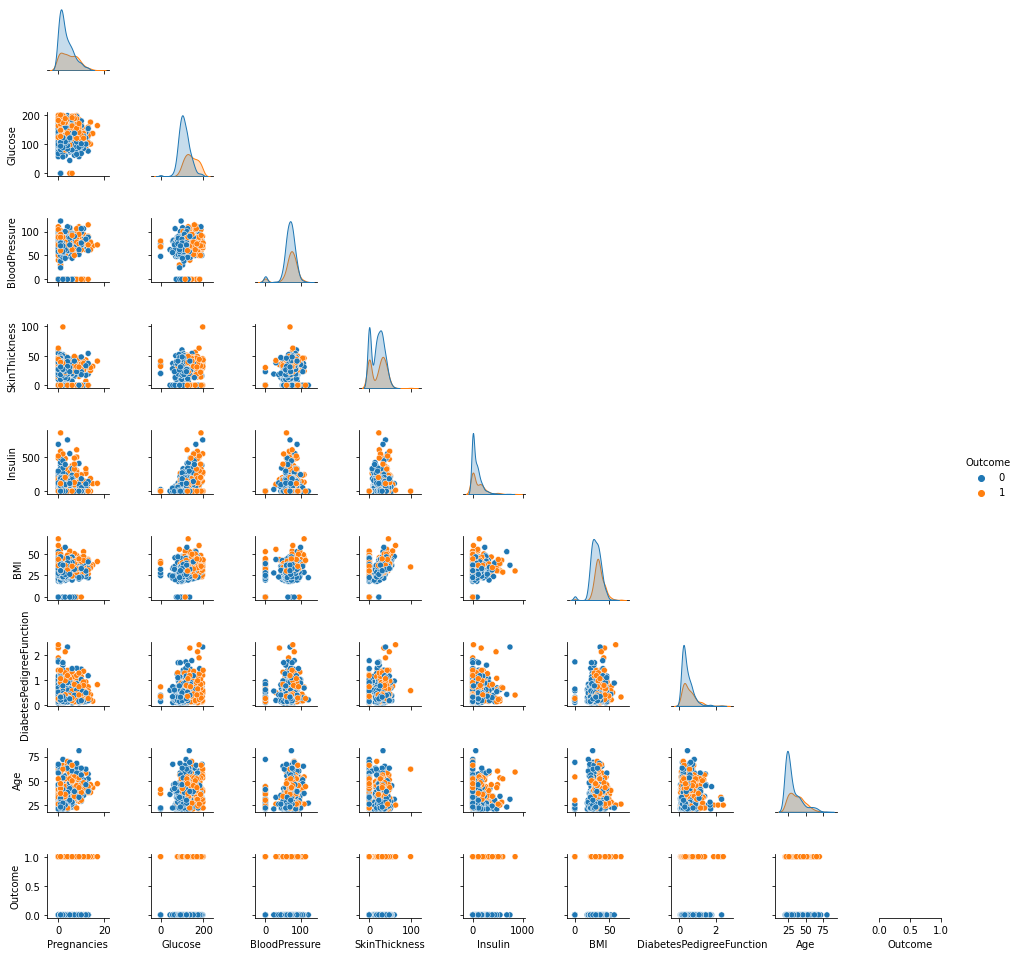

In [ ]:
sns.pairplot(diabetes_df,vars=diabetes_df.columns,hue="Outcome",size=1.5, corner=True, diag_kind="kde")

## [>](https://datascienceplus.com/machine-learning-for-diabetes-with-python/) Do Machine Learning!

*Split into Test and Training*

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(StandardScaler().fit_transform(diabetesX), diabetesY, test_size=0.5, random_state=42)

#### What is happening here?

![](https://media.springernature.com/original/springer-static/image/chp%3A10.1007%2F978-3-319-63450-0_5/MediaObjects/395337_1_En_5_Fig2_HTML.gif)

*Predict Diabetes Using ML Model*

In [ ]:
import sklearn
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(X_train, y_train.values.ravel())

*Calculate Accuracy on Test and Training Data*

In [ ]:
print("Training accuracy: {:d}%".format(round(logreg.score(X_train, y_train)*100),0))
print("Test accuracy: {:d}%".format(round(logreg.score(X_test, y_test)*100))) 

Training accuracy: 77%
Test accuracy: 79%


*Plot Weight Matrix*

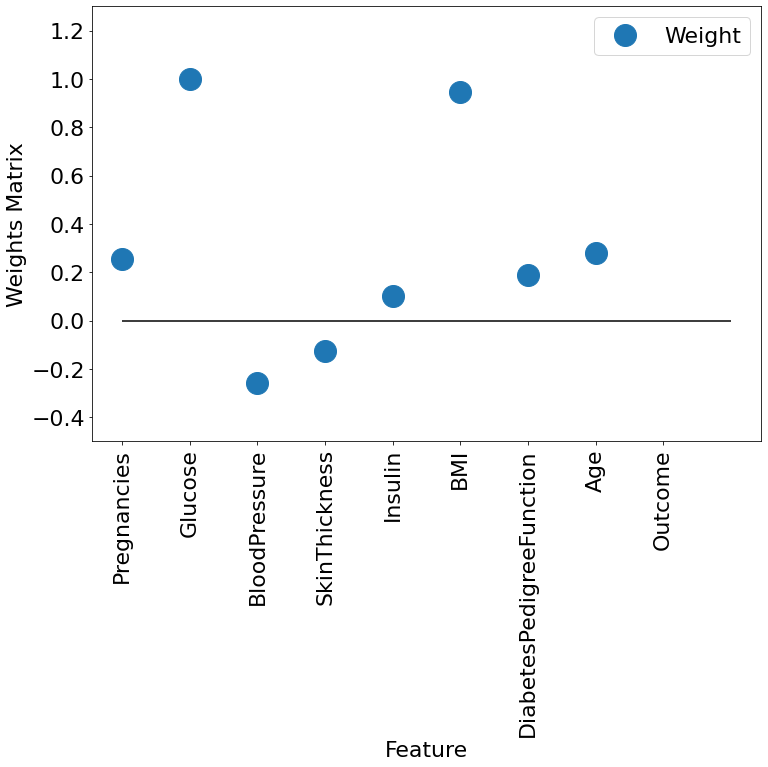

In [ ]:
import matplotlib.pyplot as plt
diabetes_features = [x for i,x in enumerate(diabetes_df.columns)]
plt.figure(figsize=(12,8))
plt.rcParams.update({'font.size': 22})
plt.plot(logreg.coef_.T, 'o', label="Weight", markersize=22)
plt.xticks(range(diabetes_df.shape[1]), diabetes_features, rotation=90)
plt.hlines(0, 0, diabetes_df.shape[1])
plt.ylim(-.5, 1.3)
plt.xlabel("Feature")
plt.ylabel("Weights Matrix")
plt.legend()

*How do we use this and what does it mean?*

LARGER numbers mean MORE important to predict the Outcome! In this example, Glucose and BMI seem to be the MOST IMPORTANT to predict diabetes in patients!

*Logistic Regression Confusion Matrix*

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
predictions = logreg.predict(X_test)
cm = metrics.confusion_matrix(y_test, predictions)
print(cm)

[[216  38]
 [ 44  86]]


Text(0.5, 1.7999999999999972, 'Predicted label')

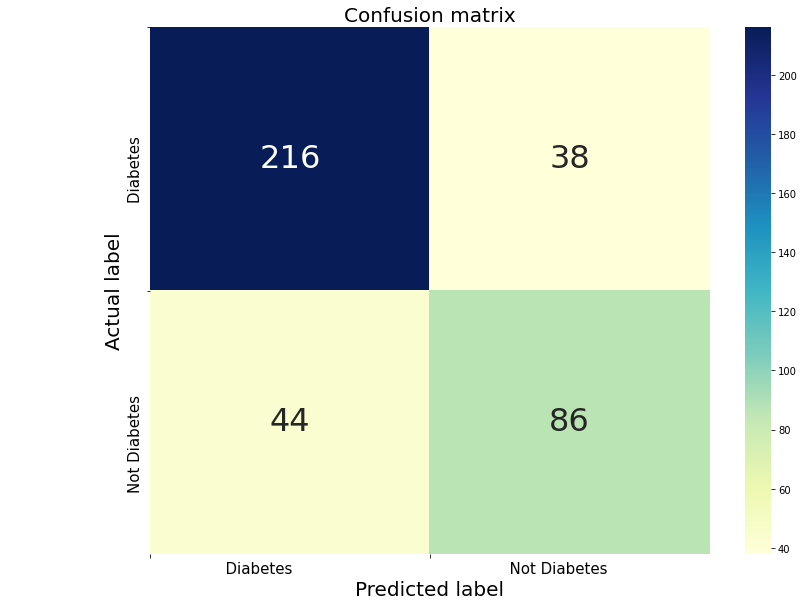

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g',annot_kws={"fontsize":32})
plt.tight_layout()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["                                              Diabetes", "                                                      Not Diabetes"], size = 15)
plt.yticks(tick_marks, ["Diabetes                        ", "Not Diabetes                       "], size = 15)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1, size = 20)
plt.ylabel('Actual label', size = 20)
plt.xlabel('Predicted label', size = 20)

 *What's missing from our model?*

The ML model has more information than just 'Diabetes' and 'Not Diabetes' but a number between 0 and 1! What could we use this for? Could we make a risk score using this as a percentage likelihood that the patient has diabetes rather than simply saying 'Diabetes' and 'Not Diabetes'?

In [ ]:
risk_score=pd.DataFrame(logreg.predict_proba(X_train))
risk_score

,0,1
0,0.731994,0.268006
1,0.830553,0.169447
2,0.328345,0.671655
3,0.789199,0.210801
4,0.971721,0.028279
...,...,...
379,0.677445,0.322555
380,0.979057,0.020943
381,0.321489,0.678511
382,0.173678,0.826322


### Save the Results in SQL

*Save Weights in SQL Database*

In [ ]:
diabetes_ml = pd.DataFrame(logreg.coef_.T) # Export Weight Matrix
diabetes_ml.columns = ['weight'] # Change column name to 'weight' 

In [ ]:
diabetes_ml["variable"] = pd.DataFrame(diabetes_features) # Include Column Names
diabetes_ml

,weight,variable
0,0.254279,Pregnancies
1,0.998293,Glucose
2,-0.258662,BloodPressure
3,-0.125226,SkinThickness
4,0.101080,Insulin
5,0.943905,BMI
6,0.186330,DiabetesPedigreeFunction
7,0.280974,Age


In [ ]:
diabetes_ml.to_sql("diabetes_ml",sqlite, if_exists="replace") # Save Pandas Dataframe to SQL

In [ ]:
!sqlite3 diabetes.csv.db ".tables" # List SQL Tables (Like Excel 'Sheets')

average_BMI   diabetes_csv  diabetes_ml 


*Make a Report of the Weights by Importance*

In [ ]:
!sqlite3 -header -column diabetes.csv.db " \
select variable,round(weight,1) as weight from diabetes_ml order by abs(weight) desc"

variable    weight    
----------  ----------
Glucose     1.0       
BMI         0.9       
Age         0.3       
BloodPress  -0.3      
Pregnancie  0.3       
DiabetesPe  0.2       
SkinThickn  -0.1      
Insulin     0.1       


In [ ]:
sqlite.close() # Disconnect from SQL

## [>](https://github.com/Anny8910/Decision-Tree-Classification-on-Diabetes-Dataset/blob/master/Diabetes_set_(Decision_tree).ipynb) Another ML Model, the Decision Tree!

*Can a simple algorithm like this be accurate?*

![](https://www.analyticsindiamag.com/wp-content/uploads/2019/01/decisn-tree.jpg)

*Split into Test and Training*

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(diabetesX, diabetesY, test_size=0.5, random_state=42) # Split into Test and Training datasets

*Fit and Visualize Decision Tree Model*

In [ ]:
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
model = DecisionTreeClassifier( max_depth=1) # Create Decision Tree classifer object
model = model.fit(X_train,y_train.values.ravel()) # Train Decision Tree Classifer

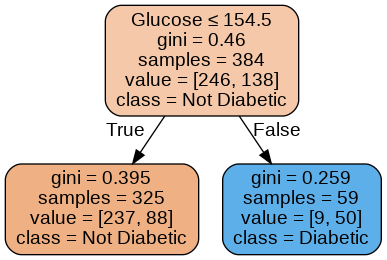

In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model, out_file=dot_data,filled=True, rounded=True,special_characters=True, feature_names = diabetesX.columns,class_names=['Not Diabetic','Diabetic'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

*Calculate Accuracy on Test and Training Data*

In [ ]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
y_pred_train = model.predict(X_train) # Predict the response for train dataset
y_pred_test = model.predict(X_test) # Predict the response for test dataset
print("Training accuracy: {:d}%".format(round(metrics.accuracy_score(y_train, y_pred_train)*100)))
print("Test accuracy: {:d}%".format(round(metrics.accuracy_score(y_test, y_pred_test)*100)))

Training accuracy: 75%
Test accuracy: 75%


[>](https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-mnist-handwriting-recognition-matplotlib-a6b31e2b166a)  *Decision Tree Confusion Matrix* 

In [ ]:
from sklearn.metrics import confusion_matrix # Evaluation using Confusion matrix
cm2=confusion_matrix(y_test,y_pred_test)
print(cm2)

[[239  15]
 [ 82  48]]


Text(0.5, 1.7999999999999972, 'Predicted label')

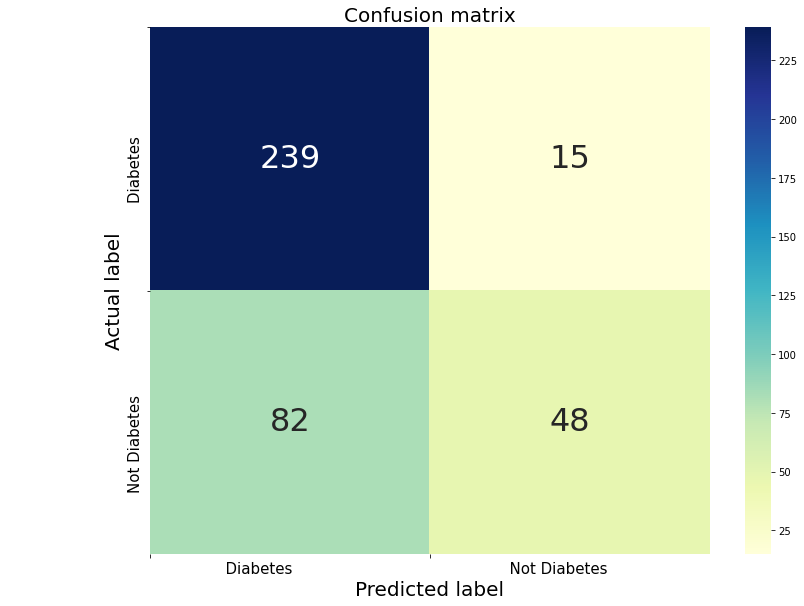

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.figure(figsize=(12,8))
sns.heatmap(pd.DataFrame(cm2), annot=True, cmap="YlGnBu" ,fmt='g',annot_kws={"fontsize":32})
plt.tight_layout()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["                                              Diabetes", "                                                      Not Diabetes"], size = 15)
plt.yticks(tick_marks, ["Diabetes                        ", "Not Diabetes                       "], size = 15)
plt.tight_layout()
plt.title('Confusion matrix', y=1.1, size = 20)
plt.ylabel('Actual label', size = 20)
plt.xlabel('Predicted label', size = 20)

What if we predict risk scores from this model?

In [ ]:
risk_score_tree=pd.DataFrame(model.predict_proba(X_train))
#pd.set_option('display.max_rows', risk_score.shape[0]+1)
risk_score_tree

,0,1
0,0.729231,0.270769
1,0.729231,0.270769
2,0.729231,0.270769
3,0.729231,0.270769
4,0.729231,0.270769
...,...,...
379,0.729231,0.270769
380,0.729231,0.270769
381,0.729231,0.270769
382,0.729231,0.270769
